In [ ]:
# Import dependencies
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch import nn, save, load
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
from torchsummary import summary

In [ ]:
# Parameters
BATCH_SIZE = 100
NUM_EPOCHS = 10
LR = 1e-3
VAL_PERCENT = 0.2

# layer 1 filter, kernel params
LAYER_1_C = 8
LAYER_1_H = 5
LAYER_1_W = LAYER_1_H

LAYER_2_C = 16
LAYER_2_H = 5
LAYER_2_W = LAYER_2_H

OUTPUT_H = (28 - LAYER_1_H + 1) - LAYER_2_H + 1
OUTPUT_W = (28 - LAYER_1_W + 1) - LAYER_2_W + 1



In [ ]:
# Get data
train = datasets.MNIST(root="data", download=True, train=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]))

val_size    = int(VAL_PERCENT * len(train))
train_size  = len(train) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(train,[train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#1,28,28 - classes 0-9

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4712830.71it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 126827.06it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:04<00:00, 359937.26it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4471955.11it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



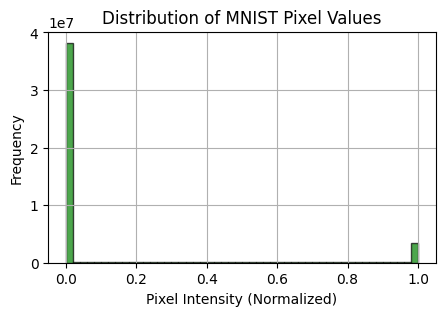

In [ ]:
plt.figure(figsize=(5, 3))
plt.hist(train.data.numpy().flatten()/255, bins=50, color='green', edgecolor='black', alpha=0.7)
plt.title('Distribution of MNIST Pixel Values')
plt.xlabel('Pixel Intensity (Normalized)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

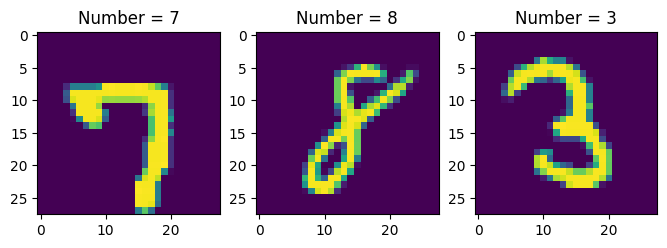

In [ ]:
#Visualizing a few images
idx = random.randint(0,1000)
fig = plt.figure(figsize=(8, 8))
rows = 1
cols = 3
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    img, label = train[i+idx]
    plt.imshow(img[0])
    plt.title("Number = " + str(label))
plt.show()



In [ ]:
# Image Classifier Neural Network
class ImageClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, LAYER_1_C, (LAYER_1_H, LAYER_1_W)),
            nn.ReLU(),
            nn.Conv2d(LAYER_1_C, LAYER_2_C, (LAYER_2_H, LAYER_2_W)),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(LAYER_2_C * OUTPUT_H * OUTPUT_W, 10)
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
# Instance of the neural network, loss, optimizer
clf = ImageClassifier().to(device)
opt = Adam(clf.parameters(), lr=LR)
loss_fn = nn.CrossEntropyLoss()

summary(clf, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 24, 24]             208
              ReLU-2            [-1, 8, 24, 24]               0
            Conv2d-3           [-1, 16, 20, 20]           3,216
              ReLU-4           [-1, 16, 20, 20]               0
           Flatten-5                 [-1, 6400]               0
            Linear-6                   [-1, 10]          64,010
Total params: 67,434
Trainable params: 67,434
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.22
Params size (MB): 0.26
Estimated Total Size (MB): 0.48
----------------------------------------------------------------


In [ ]:
# Training flow
losses = []
accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(10): # train for 10 epochs
    for batch in train_loader:
        X,y = batch
        X, y = X.to(device), y.to(device)
        yhat = clf(X)
        loss = loss_fn(yhat, y)

        # Apply backprop
        opt.zero_grad()
        loss.backward()
        opt.step()

    _, predicted = torch.max(yhat.data, 1)
    acc = (predicted == y).sum().item() / y.size(0)
    accuracies.append(acc)
    losses.append(loss.item())

    val_loss = 0.0
    val_acc = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = clf(images)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total = labels.size(0)
        correct = (predicted == labels).sum().item()
        val_acc += correct / total
        val_accuracies.append(acc)
        val_losses.append(loss.item())

    print('Epoch [{}/{}],   Loss:{:.4f},    Val Loss:{:.4f},    Accuracy:{:.2f},    Val Accuracy:{:.2f}'.format(
        epoch+1, NUM_EPOCHS, loss.item(), val_loss, acc ,val_acc))

Epoch [1/10],   Loss:0.0645,    Val Loss:9.7381,    Accuracy:0.96,    Val Accuracy:0.98
Epoch [2/10],   Loss:0.0266,    Val Loss:8.0956,    Accuracy:0.99,    Val Accuracy:1.00
Epoch [3/10],   Loss:0.0265,    Val Loss:6.2532,    Accuracy:0.98,    Val Accuracy:0.99
Epoch [4/10],   Loss:0.0153,    Val Loss:5.9287,    Accuracy:0.99,    Val Accuracy:1.00
Epoch [5/10],   Loss:0.0214,    Val Loss:5.7650,    Accuracy:1.00,    Val Accuracy:0.98
Epoch [6/10],   Loss:0.0427,    Val Loss:7.4890,    Accuracy:1.00,    Val Accuracy:0.99
Epoch [7/10],   Loss:0.0258,    Val Loss:6.8033,    Accuracy:1.00,    Val Accuracy:0.98
Epoch [8/10],   Loss:0.0214,    Val Loss:7.6900,    Accuracy:1.00,    Val Accuracy:0.98
Epoch [9/10],   Loss:0.0074,    Val Loss:8.2968,    Accuracy:1.00,    Val Accuracy:1.00
Epoch [10/10],   Loss:0.0103,    Val Loss:9.3389,    Accuracy:1.00,    Val Accuracy:1.00


In [ ]:
PATH = "model.pt"

torch.save({"model_state_dict":clf.state_dict()}, PATH)